In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor

from tqdm import tqdm 

In [24]:
device = torch.device("cuda")

### Model

S x S grid

predicitons = S * S * ( B * 5 + C )

24 convs + 2 fc

pretrain conv on ImageNet

input image = 448 * 448

output = 7 * 7 * 30

In [2]:
class ConvLayers(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=192, kernel_size=7, stride=2, padding=3)  
        self.bn1 = nn.BatchNorm2d(192)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(256)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512)
        )
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_5 = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
                nn.BatchNorm2d(256),
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
            ) for _ in range(4)]
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
        )
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4_5 = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),  
                nn.BatchNorm2d(1024),
            ) for _ in range(2)]
        )
        
        # The upper layers are used for pretraining on ImageNet
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),  
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
        )
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),  
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024)
        )
    
    def preTrain(self, x):
        x = self.maxpool1(F.leaky_relu(self.conv1(x)))
        x = self.maxpool2(F.leaky_relu(self.conv2(x)))
        x = self.maxpool3(F.leaky_relu(self.conv3(x)))
        x = self.maxpool4(F.leaky_relu(self.conv4(x)))
        
        return x
    
    def forward(self, x):
        x = self.maxpool1(F.leaky_relu(self.conv1(x)))
        x = self.maxpool2(F.leaky_relu(self.conv2(x)))
        x = self.maxpool3(F.leaky_relu(self.conv3(x)))
        x = self.maxpool4(F.leaky_relu(self.conv4(x)))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        
        return x

In [3]:
class FCLayers(nn.Module):
    def __init__(self, S, B, C):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        
        self.fc1 = nn.Linear(7*7*1024, 4096)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, self.S * self.S* (self.B * 5 + self.C))
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [4]:

class YOLOv1(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        
        self.S = 7
        self.B = 2
        self.C = num_classes
        self.coord_scale = 5
        self.noobj_scale = 0.5
        
        self.convLayers = ConvLayers()
        self.fcLayers = FCLayers(self.S, self.B, self.C)
        
        
    def forward(self, x):
        x = self.convLayers(x)
        x = self.fcLayers(x)
        x = x.view(-1, self.S, self.S, self.B * 5 + self.C)
        return x
    
    def loss_fn(self, predictions, targets):
        pred_bboxes, pred_confs, pred_classes = self.destruct(predictions)
        true_bboxes, true_confs, true_classes = self.destruct(targets)

        iou = self.findIOU(pred_bboxes, true_bboxes)
        best_iou_mask = self.get_best_iou_mask(iou)

        obj_mask = true_confs > 0 
        no_obj_mask = ~obj_mask   

        responsible_mask = torch.zeros_like(pred_confs, dtype=torch.bool)
        responsible_mask.scatter_(-1, best_iou_mask, 1)

        xy_loss = F.mse_loss(
            pred_bboxes[..., :2][obj_mask & responsible_mask],
            true_bboxes[..., :2][obj_mask & responsible_mask],
            reduction='sum'
        )
        wh_loss = F.mse_loss(
            torch.sqrt(torch.clamp(pred_bboxes[..., 2:4][obj_mask & responsible_mask], min=1e-6)),
            torch.sqrt(torch.clamp(true_bboxes[..., 2:4][obj_mask & responsible_mask], min=1e-6)),
            reduction='sum'
        )

        bbox_loss = self.coord_scale * (xy_loss + wh_loss)

        obj_conf_loss = F.mse_loss(
            pred_confs[obj_mask & responsible_mask],
            true_confs[obj_mask & responsible_mask],
            reduction='sum'
        )
        
        no_obj_conf_loss = F.mse_loss(
            pred_confs[no_obj_mask],
            true_confs[no_obj_mask],
            reduction='sum'
        )
        conf_loss = obj_conf_loss + self.noobj_scale * no_obj_conf_loss

        grid_obj_mask = obj_mask.any(dim=-1)

        class_loss = F.mse_loss(
            pred_classes[grid_obj_mask],
            true_classes[grid_obj_mask],
            reduction='sum'
        )

        total_loss = bbox_loss + conf_loss + class_loss
        return total_loss / predictions.shape[0] 
    
    def destruct(self, x, B=None):
        if B is None:
            B = self.B 
        bboxes_and_confs = x[..., :B * 5].view(-1, self.S, self.S, B, 5)
        bboxes = bboxes_and_confs[..., :4]
        confs = bboxes_and_confs[..., 4]
        classes = x[..., -self.C:]
        
        return bboxes, confs, classes
    
    def findIOU(self, pred_bboxes, true_bboxes):
        pred_tl, pred_br = self.bbox_to_coords(pred_bboxes)
        true_tl, true_br = self.bbox_to_coords(true_bboxes)
        
        inter_tl = torch.max(pred_tl, true_tl)
        inter_br = torch.min(pred_br, true_br)
        inter_wh = torch.clamp(inter_br - inter_tl, min=0)
        intersection = inter_wh[..., 0] * inter_wh[..., 1]

        pred_area = (pred_br[..., 0] - pred_tl[..., 0]) * (pred_br[..., 1] - pred_tl[..., 1])
        true_area = (true_br[..., 0] - true_tl[..., 0]) * (true_br[..., 1] - true_tl[..., 1])
        union = pred_area + true_area - intersection

        iou = intersection / (union + 1e-6)
        iou[union == 0] = 0 

        return iou

    def bbox_to_coords(self, bboxes):
        x, y, w, h = bboxes[..., 0], bboxes[..., 1], bboxes[..., 2], bboxes[..., 3]
        tl = torch.stack((x - w / 2, y - h / 2), dim=-1)
        br = torch.stack((x + w / 2, y + h / 2), dim=-1)
        return tl, br

    def get_best_iou_mask(self, iou):
        best_iou_idx = torch.argmax(iou, dim=-1)
        return best_iou_idx.unsqueeze(-1)

### Dataset

In [5]:
files_dir = 'dataset_fruit/train_zip/train'
test_dir = 'dataset_fruit/test_zip/test'

images = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)

test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [25]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=files_dir, S=7, B=2, C=3, transform=None, image_size=(416, 416)):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.image_size = image_size
        self.resize = Resize(self.image_size)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()
        
        class_dictionary = {'apple':0, 'banana':1, 'orange':2}

        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")
        
        img_width, img_height = image.size
        for member in root.findall('object'):
            klass = member.find('name').text
            klass = class_dictionary[klass]
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            centerx = ((xmax + xmin) / 2) / img_width
            centery = ((ymax + ymin) / 2) / img_height
            boxwidth = (xmax - xmin) / img_width
            boxheight = (ymax - ymin) / img_height
            
            boxes.append([klass, centerx, centery, boxwidth, boxheight])
        
        boxes = torch.tensor(boxes)
        image = self.resize(image)
        image = ToTensor()(image)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return image.to(device), label_matrix.to(device)

    
def show_image(image):
    plt.imshow(image.permute(1, 2, 0).numpy())

In [26]:
BATCH_SIZE = 16

train_dataset = FruitImagesDataset(
    files_dir=files_dir,
    image_size=(448, 448)
)

test_dataset = FruitImagesDataset(
    files_dir=test_dir,
    image_size=(448, 448)
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
)

In [8]:
image, label = next(iter(train_loader))

In [9]:
image.shape

torch.Size([16, 3, 448, 448])

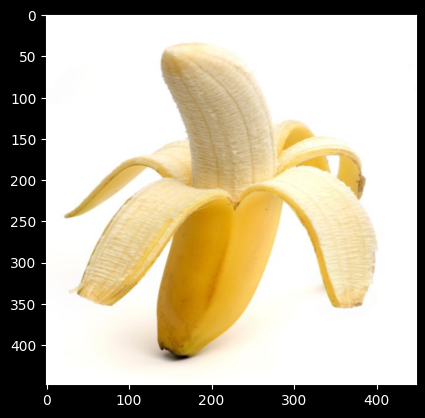

In [10]:
plt.imshow(image[0].permute(1, 2, 0).detach().numpy())

In [27]:
lr = 1e-1
model = YOLOv1(num_classes=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-1)
loss_fn = model.loss_fn

In [29]:
losses = []
ud = []

epochs = 1
for epoch in range(epochs):
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        pred = model(images)
        
        optimizer.zero_grad()
        loss = loss_fn(pred, targets)
        loss.backward()
        
        optimizer.step()
        
        with torch.no_grad():
            losses.append(loss.log10().item())
            ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters() if p.grad is not None])

Epoch 1/1:  13%|█▎        | 2/15 [00:06<00:41,  3.20s/it]c:\Python311\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/1: 100%|██████████| 15/15 [00:45<00:00,  3.02s/it]


In [30]:
losses

[10.242753982543945,
 12.001869201660156,
 10.465702056884766,
 9.477044105529785,
 9.285528182983398,
 8.894844055175781,
 9.077717781066895,
 8.012550354003906,
 8.368438720703125,
 8.783154487609863,
 8.313283920288086,
 9.198504447937012,
 9.285213470458984,
 9.175212860107422,
 9.058914184570312]

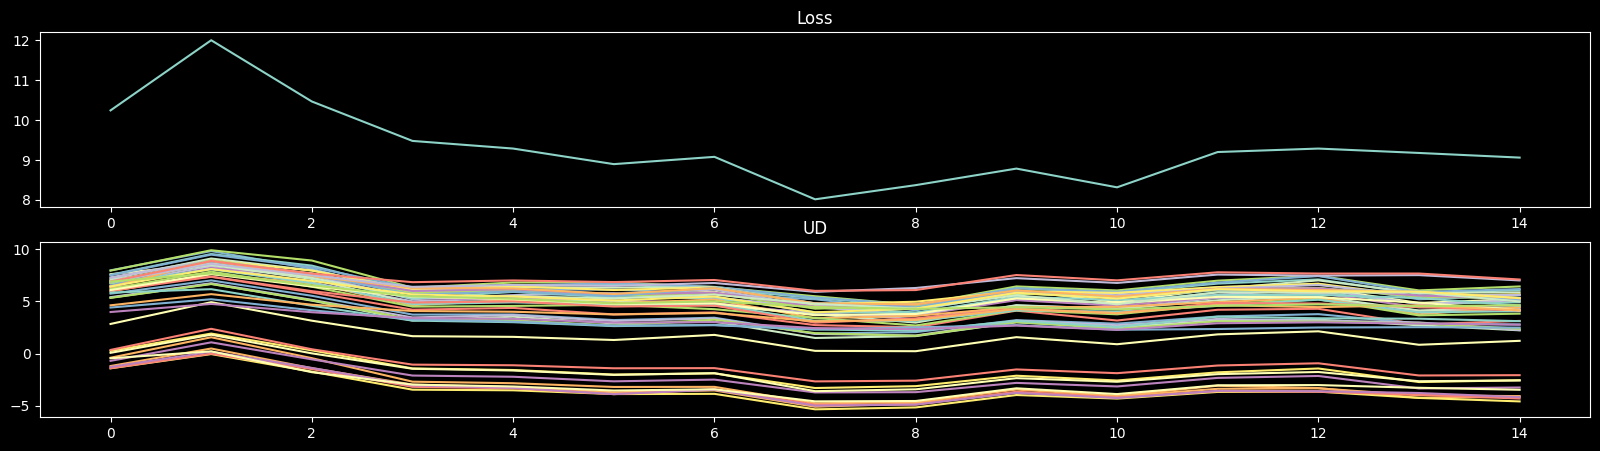

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 5))

axs[0].plot(losses)
axs[0].set_title("Loss")

axs[1].plot(ud)
axs[1].set_title("UD")

plt.show()